In [1]:
import analysis
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sg
import scipy.interpolate as interp
import seaborn as sns
import time
from tqdm import tqdm
from line_least_cost import llc

%matplotlib inline

#based on the following paper
#https://ws680.nist.gov/publication/get_pdf.cfm?pub_id=901379

/processed


In [2]:
data_path = 'SH_031_04192017_EDITS.txt'
meants_path = 'moion_meants.txt'

In [21]:
data = pd.read_csv(data_path, sep='\t|,', names=['Time', 'O2', 'CO2'],
                 usecols=['Time', 'O2', 'CO2'], index_col=False)[['Time', 'O2', 'CO2']]
filtered_O2 = analysis.fourier_filter_no_resample(data.Time, data.O2, 3,100)
filtered_CO2 = analysis.fourier_filter_no_resample(data.Time, data.CO2, 3,100)

meants = np.loadtxt(meants_path, delimiter='\n')
meants_ts = np.linspace(0,480,len(meants))
filtered_ts = np.linspace(0,480, len(data.O2))

if(data.Time[len(data.Time)-1] < 10):
    data.Time = data.Time * 60

/Users/borainbow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [22]:
def get_centroid(t_series, data_series):
    """
    centroid is a signal weighted average of time. We are essentially calculating the temporal middle of the signal
    
    t_series = time points of data_series
    data_series = the signal intensity series
    """
    #set buffer to 0
    buffer = 0.0 
    #pack t_series and d_series together and calculate square weighted sum
    for t, d in zip(t_series, data_series):
        buffer += (d**2) * t
    #return square weighted average
    return buffer/(np.sum(data_series**2))


#############################################
cent_meants = get_centroid(meants_ts, sg.savgol_filter(meants,21,3))
cent_meants_noFilter = get_centroid(meants_ts, meants)
cent_O2 = get_centroid(data.Time, sg.savgol_filter(filtered_O2,21,3))
cent_CO2 = get_centroid(data.Time, sg.savgol_filter(filtered_CO2,21,3))

print(cent_meants, cent_meants_noFilter)
        

240.7415802306184 240.60506041459325


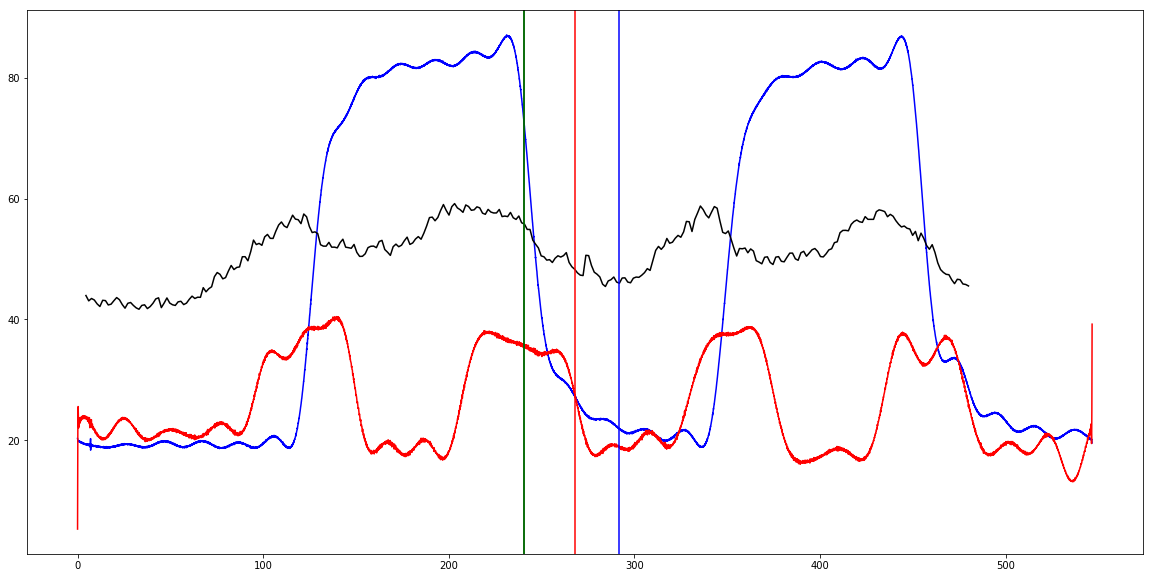

In [24]:
plt.figure(figsize=(20,10))
# plt.plot(filtered_ts, filtered_O2, color='blue')
# plt.plot(filtered_ts, filtered_CO2, color='red')

plt.plot(data.Time, filtered_O2, color='blue')
plt.plot(data.Time, sg.savgol_filter(filtered_CO2,25,3), color='red')
plt.plot(meants_ts[3:], meants[3:]-300, color='black') #shifted meants downwards
plt.axvline(x= cent_meants, color = 'black')
plt.axvline(x= cent_O2, color ='blue')
plt.axvline(x= cent_CO2, color='red')
plt.axvline(x= cent_meants_noFilter, color='green')

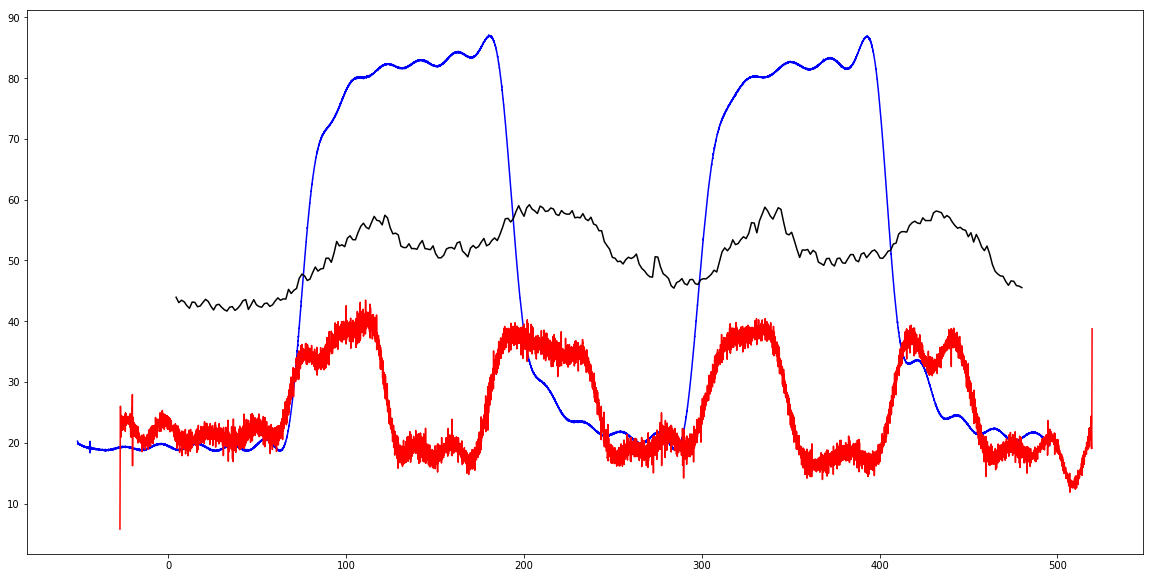

In [25]:
plt.figure(figsize=(20,10))
plt.plot(data.Time-(cent_O2 - cent_meants), filtered_O2, color='blue')
plt.plot(data.Time-(cent_CO2 - cent_meants), filtered_CO2, color='red')
plt.plot(meants_ts[3:], meants[3:]-300, color='black')

In [26]:
O2_resampler = interp.interp1d(data.Time-(cent_O2 - cent_meants), filtered_O2, fill_value = 'extrapolate')
CO2_resampler = interp.interp1d(data.Time-(cent_CO2 - cent_meants), filtered_CO2, fill_value= ' extrapolate')

O2_exact_aligned = O2_resampler(meants_ts)
CO2_exact_aligned = CO2_resampler(meants_ts)

In [27]:

#cut data to correct lenghts

O2_exact_aligned = (O2_exact_aligned/np.max(O2_exact_aligned))[3:]
CO2_exact_aligned = (CO2_exact_aligned/np.max(CO2_exact_aligned))[3:]
meants =  meants[3:]-323
meants_ts = meants_ts[3:]

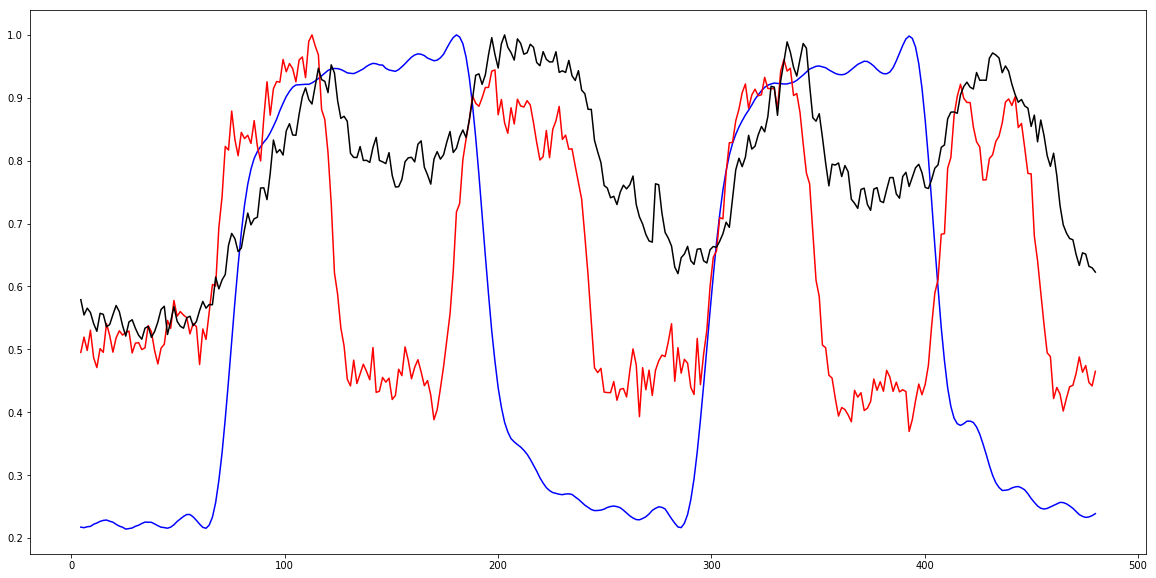

In [28]:
plt.figure(figsize=(20,10))
plt.plot(meants_ts, O2_exact_aligned, color='blue')
plt.plot(meants_ts, CO2_exact_aligned, color='red')
plt.plot(meants_ts, meants/np.max(meants), color='black')



In [29]:
def get_cost(C1, C2, C3, sig1, sig2, composite_sig):
    """
    mean squared error for a linear combination of 2 independent signals
    
    C1 = constant for sig1
    C2 = constant for sig2
    sig1 = signal 1
    sig2 = signal 2 
    composite_sig = observed additive combination of sig1 and sig2
    """
    if((len(sig1) + len(sig2) + len(composite_sig))/len(sig1) != 3):
        print("ERROR: signals are not the same length")
        return np.nan
    else:
        return(np.sum((C1*sig1 + C2*sig2 + C3 - composite_sig)**2)/len(sig1))

In [30]:
#construct cost array
cost_dict = {'C1' : [], 'C2' : [], 'Cost' : []}
for c1 in np.arange(0,100,1):
    for c2 in np.arange(0,100,1):
        cost_dict['C1'].append(c1)
        cost_dict['C2'].append(c2)
        cost_dict['Cost'].append(get_cost(c1,c2, 0,O2_exact_aligned, CO2_exact_aligned, meants))
cost_df = pd.DataFrame(cost_dict)
print(cost_df.head())

   C1  C2        Cost
0   0   0  820.844591
1   0   1  783.791108
2   0   2  747.644528
3   0   3  712.404852
4   0   4  678.072080


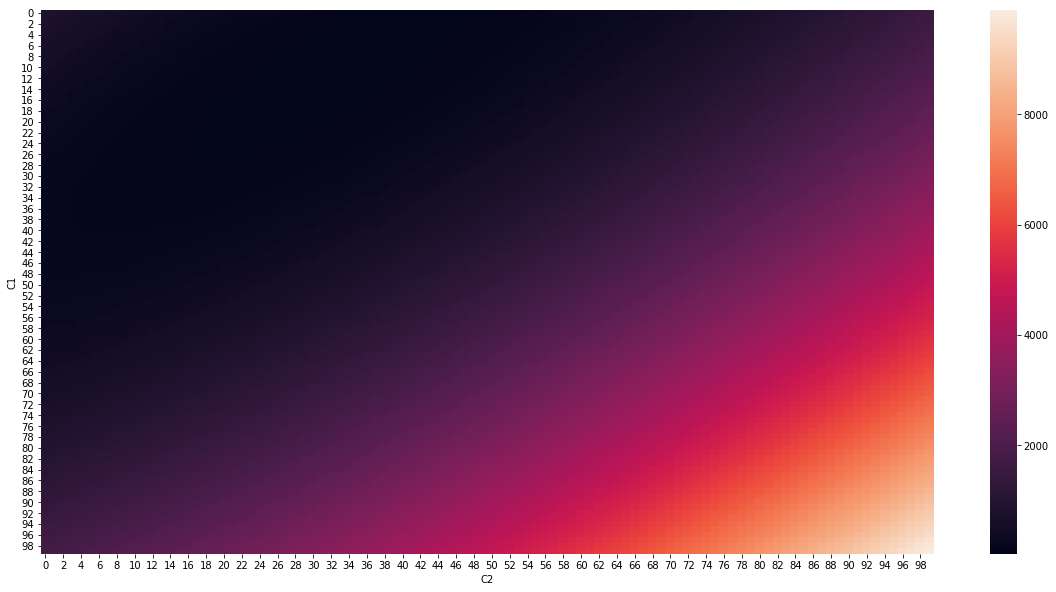

In [31]:
sns_pivot = cost_df.pivot('C1','C2','Cost')
plt.figure(figsize=(20,10))
sns.heatmap(sns_pivot)

In [32]:
def grad_constant(c1,c2,c3,s1n, s2n, bn):
    return(2*(c1*s1n + c2*s2n + c3 - bn))
def grad_C1(C1, C2, C3, S1, S2, B):
    buffer = 0.0
#     print("______________________________________________________________________________")
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn) * s1n/len(S1)
#         print(buffer)
    return buffer

def grad_C2(C1, C2, C3, S1, S2, B):
    buffer = 0.0
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn) * s2n/len(S1)
    return buffer

def grad_C3(C1, C2, C3, S1, S2, B):
    buffer = 0.0
    for s1n, s2n, bn in zip(S1, S2, B):
        buffer += grad_constant(C1, C2, C3, s1n, s2n, bn)/len(S1)
    return buffer

def descend(init_tuple, S1, S2, B, descent_speed=.1, lifespan = 100, epochs = 3):
    curr_C1 = init_tuple[0]
    curr_C2 = init_tuple[1]
    curr_C3 = init_tuple[2]

    
    for precision in range(epochs):
        print('EPOCH:     ', precision)
        time.sleep(.25)
        for i in tqdm(range(lifespan)):
            curr_C1 = curr_C1 - (descent_speed**(precision+1)* grad_C1(curr_C1, curr_C2, curr_C3, S1, S2, B))
#             print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n",descent_speed**(precision+1), curr_C1)
            curr_C2 = curr_C2 - (descent_speed**precision)* grad_C1(curr_C1, curr_C2, curr_C3, S1, S2, B)
            curr_C3 = curr_C3 - (descent_speed**precision)* grad_C1(curr_C1, curr_C2, curr_C3, S1, S2, B)
    return_tuple = (curr_C1, curr_C2, curr_C3)
    return return_tuple
    

In [33]:
predicted_coeffs = descend((.44,.72,0), O2_exact_aligned, CO2_exact_aligned, meants)

EPOCH:      0


100%|██████████| 100/100 [00:00<00:00, 551.93it/s]


EPOCH:      1


100%|██████████| 100/100 [00:00<00:00, 563.67it/s]


EPOCH:      2


100%|██████████| 100/100 [00:00<00:00, 516.94it/s]


In [34]:
print(predicted_coeffs)

(3.5971516799420997, 29.543549294855524, 7.081298194645263)


In [35]:
print(get_cost(predicted_coeffs[0],predicted_coeffs[1],predicted_coeffs[2],O2_exact_aligned,CO2_exact_aligned, meants))

22.57073502127157


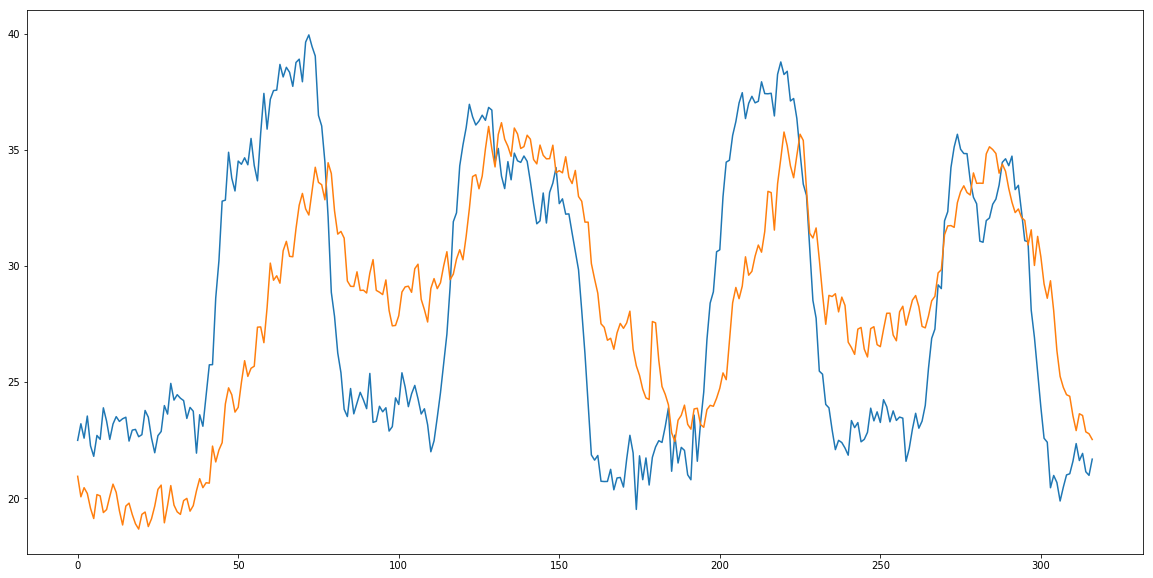

In [36]:
predicted_meants = predicted_coeffs[0]*O2_exact_aligned + predicted_coeffs[1]*CO2_exact_aligned +predicted_coeffs[2]
plt.figure(figsize=(20,10))
plt.plot(predicted_meants)
plt.plot(meants)